In [1]:
# import glob
# import os
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import lit
# from functools import reduce

# folder_path = "C://Users//Mariana//OneDrive//6. Kaggle//Problematic Internet Use//kaggle-problematic-internet-use//child-mind-institute-problematic-internet-use//series_train.parquet//"
# file_paths = glob.glob(os.path.join(folder_path, '**', '*.parquet'), recursive=True)

# spark = SparkSession.builder \
#     .appName("ParquetWriter") \
#     .config("spark.driver.memory", "4g") \
#     .config("spark.hadoop.home.dir", "C:/hadoop/hadoop-3.3.6") \
#     .getOrCreate()

# # Contar arquivos antes de iniciar
# total_files = len(file_paths)
# print(f"Total de arquivos a serem lidos: {total_files}")

# # Lista para acumular DataFrames
# dataframes = []

# # Loop para ler e acumular os DataFrames
# for i, file_path in enumerate(file_paths):
#     folder_id = os.path.basename(os.path.dirname(file_path)).split('=')[-1]
#     print(f"Lendo arquivo {i + 1} de {total_files}: {file_path}")
    
#     # Ler o arquivo e adicionar a coluna de ID
#     df = spark.read.parquet(file_path).withColumn("id", lit(folder_id))
    
#     # Adicionar o DataFrame com o ID à lista
#     dataframes.append(df)

# # Concatenar todos os DataFrames usando `union`
# df_spark = reduce(lambda df1, df2: df1.union(df2), dataframes)


In [2]:
train_folder_path = "C://Users//Mariana//OneDrive//6. Kaggle//Problematic Internet Use//kaggle-problematic-internet-use//child-mind-institute-problematic-internet-use//series_train.parquet//"
test_folder_path = "C://Users//Mariana//OneDrive//6. Kaggle//Problematic Internet Use//kaggle-problematic-internet-use//child-mind-institute-problematic-internet-use//series_test.parquet//"

In [3]:
# df_spark.printSchema()

In [4]:
import pandas as pd 
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def process(filename, directory):
    df = pd.read_parquet(os.path.join(directory, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    idx = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        data = list(tqdm(executor.map(lambda x: process(x, dirname), idx), total=len(idx)))
    
    stats, indexes = zip(*data)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

In [5]:
import os
train_series_data = load_time_series(train_folder_path)
test_series_data = load_time_series(test_folder_path)

100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


In [6]:
train_series_data.to_csv('train_series_data_stats.csv')
test_series_data.to_csv('test_series_data_stats.csv')

In [5]:
df_spark.show()

+----+-----------+------------+-----------+-----------+----------+-------------+---------+---------------+--------------+-------+-------+-------------------+--------+
|step|          X|           Y|          Z|       enmo|    anglez|non-wear_flag|    light|battery_voltage|   time_of_day|weekday|quarter|relative_date_PCIAT|      id|
+----+-----------+------------+-----------+-----------+----------+-------------+---------+---------------+--------------+-------+-------+-------------------+--------+
|   0|0.021536458| 0.022213541| -1.0223697|0.022852687| -88.28076|          0.0|     53.0|         4188.0|56940000000000|      4|      3|               41.0|00115b9f|
|   1|0.022005208|   0.0221875| -1.0197396| 0.02023127| -88.24171|          0.0|51.666668|      4188.1665|56945000000000|      4|      3|               41.0|00115b9f|
|   2|0.022239583| 0.022005208| -1.0194011| 0.01989267| -88.17007|          0.0|50.333332|      4188.3335|56950000000000|      4|      3|               41.0|00115b9f

In [7]:
filtered_df = df_spark.filter(df_spark.id == '00115b9f')

In [9]:
filtered_df = filtered_df.toPandas()

In [11]:
filtered_df.describe()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
count,43330.000000,43330.000000,43330.000000,43330.000000,43330.000000,43330.000000,43330.0,43330.000000,43330.000000,4.333000e+04,43330.000000,43330.0,43330.000000
mean,21664.500000,-0.316384,0.016009,-0.167890,0.047388,-10.580416,0.0,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683
std,12508.437919,0.453665,0.502702,0.585710,0.106351,42.947170,0.0,208.168976,112.404045,1.942842e+13,1.931421,0.0,14.244915
min,0.000000,-1.746094,-2.905339,-1.048372,0.000000,-89.833092,0.0,0.000000,3824.000000,5.500000e+10,1.000000,3.0,41.000000
25%,10832.250000,-0.684180,-0.309863,-0.649974,0.006432,-41.541863,0.0,2.392969,4028.666748,3.689000e+13,3.000000,3.0,42.000000
50%,21664.500000,-0.366849,0.024974,-0.245378,0.023637,-15.086617,0.0,6.926828,4070.000000,5.347750e+13,5.000000,3.0,50.000000
75%,32496.750000,-0.010677,0.400677,0.204727,0.041420,12.220764,0.0,15.000000,4147.000000,6.640875e+13,6.000000,3.0,53.000000
max,43329.000000,1.507865,1.666354,1.546979,4.004276,89.751656,0.0,2633.250000,4188.500000,8.611000e+13,7.000000,3.0,85.000000


In [15]:
from pyspark.sql import functions as F

df_spark_agrup = df_spark.groupBy("id").agg(
    F.avg("x").alias("avg_accel_x"),
    F.avg("y").alias("avg_accel_y"),
    F.avg("z").alias("avg_accel_z"),
    F.avg("enmo").alias("avg_enmo"),
    F.avg("anglez").alias("avg_anglez"),
    F.sum("non-wear_flag").alias("sum_non_wear_flag"),
    F.avg("light").alias("avg_light")
)

# Mostrar o resultado
df_spark_agrup.show()


+--------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+------------------+
|      id|         avg_accel_x|         avg_accel_y|         avg_accel_z|            avg_enmo|         avg_anglez| sum_non_wear_flag|         avg_light|
+--------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+------------------+
|00115b9f|-0.31638350708708524|0.016008794383341674|-0.16789009855398757| 0.04738761215892113|-10.580415352776383|               0.0| 42.29630926816121|
|001f3379|-0.00427225722321...|0.016858876541917523| -0.6317314230275448|0.011926252442999804|-55.630767828372576|259920.00000890344|16.771980609246814|
+--------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+------------------+



In [ ]:
df_spark_agrup.toPandas().to_csv('df_series_all_agrup_test.csv')

In [21]:
import pandas as pd

df_train = pd.read_csv('C:/Users/Mariana/OneDrive/6. Kaggle/Problematic Internet Use/kaggle-problematic-internet-use/child-mind-institute-problematic-internet-use/train.csv')


In [22]:
df_train.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,...,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,...,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,...,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000
75%,13.000000,1.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,...,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000
max,22.000000,1.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000


In [26]:
df_train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_spark_agrup.count()

996

In [30]:
df_series = df_spark_agrup.toPandas()

In [31]:
# df_series.to_csv('df_series_all_agrup.csv')

In [32]:
df_final = df_train.merge(df_series, on="id", how="left")

In [33]:
df_final.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,avg_accel_x,avg_accel_y,avg_accel_z,avg_enmo,avg_anglez,sum_non_wear_flag,avg_light
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,Winter,0.0,1.0,-0.316384,0.016009,-0.16789,0.047388,-10.580415,0.0,42.296309
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
import numpy as np
df_final[~df_final['avg_accel_y'].isna()]

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,avg_accel_x,avg_accel_y,avg_accel_z,avg_enmo,avg_anglez,sum_non_wear_flag,avg_light
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,...,Winter,0.0,1.0,-0.316384,0.016009,-0.167890,0.047388,-10.580415,0.000000,42.296309
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,...,Spring,0.0,1.0,-0.004272,0.016859,-0.631731,0.011926,-55.630768,259920.000009,16.771981
20,00f332d1,Winter,14,0,Spring,68.0,Spring,17.168636,66.50,108.0,...,Winter,2.0,1.0,0.208036,0.057094,0.141550,0.030255,6.687339,70961.500003,66.563397
22,01085eb3,Fall,12,0,Winter,58.0,Fall,34.187282,60.50,178.0,...,Fall,0.0,0.0,-0.343396,-0.055826,-0.254433,0.032946,-17.589037,13061.500000,17.800735
25,012cadd8,Spring,9,0,Winter,60.0,Fall,17.089151,53.20,68.8,...,Spring,0.0,0.0,0.018670,0.071660,-0.061682,0.058280,-5.059758,0.000000,54.893401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,fe9c71d8,Winter,9,0,Spring,80.0,Winter,15.891137,56.75,72.8,...,Winter,0.0,0.0,0.083682,0.001779,0.215386,0.043686,14.617012,58565.500004,7.297878
3947,fecc07d6,Fall,7,0,Spring,85.0,Winter,15.986589,49.00,54.6,...,Fall,0.0,0.0,0.037227,0.003576,-0.891608,0.002962,-78.010130,389069.500005,50.648312
3951,ff18b749,Spring,7,0,NaN,NaN,Summer,14.768842,47.50,47.4,...,Spring,0.0,0.0,0.035303,-0.015518,-0.042806,0.053595,-3.630944,0.000000,94.217119
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.00,109.8,...,Fall,0.0,1.0,0.377523,-0.136917,-0.190546,0.028601,-12.374898,8460.000001,22.480033


In [39]:
df_final.to_csv('df_final_1.csv')

In [58]:
import pandas as pd

df=pd.read_csv("df_final_1.csv")

In [3]:
df.head()

,Unnamed: 0,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,...,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,avg_accel_x,avg_accel_y,avg_accel_z,avg_enmo,avg_anglez,sum_non_wear_flag,avg_light
0,0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,...,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,...,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,...,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,...,Winter,0.0,1.0,-0.316384,0.016009,-0.16789,0.047388,-10.580415,0.0,42.296309
4,4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


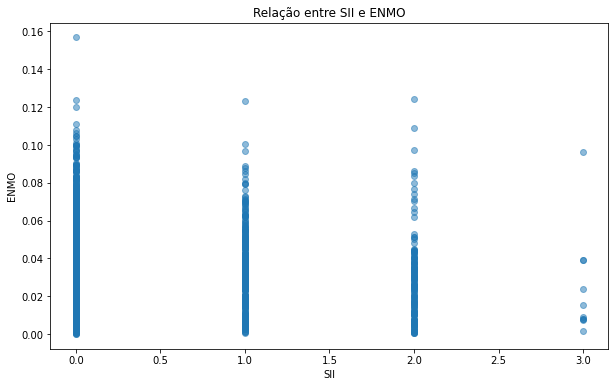

,Unnamed: 0,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,...,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,avg_accel_x,avg_accel_y,avg_accel_z,avg_enmo,avg_anglez,sum_non_wear_flag,avg_light
0,0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,...,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,...,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,...,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,...,Winter,0.0,1.0,-0.316384,0.016009,-0.167890,0.047388,-10.580415,0.000000,42.296309
4,4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,...,Fall,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3956,3956,ffa9794a,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,...,Winter,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3957,3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,...,Fall,0.0,1.0,0.377523,-0.136917,-0.190546,0.028601,-12.374898,8460.000001,22.480033
3958,3958,ffed1dd5,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,...,Spring,1.0,0.0,0.044563,0.080560,0.339411,0.017076,27.160028,236340.000014,7.501198


In [6]:
import matplotlib.pyplot as plt

# Plotar o gráfico de dispersão (scatterplot) para visualizar a relação
plt.figure(figsize=(10, 6))
plt.scatter(df['sii'], df['avg_enmo'], alpha=0.5)
plt.xlabel('SII')
plt.ylabel('ENMO')
plt.title('Relação entre SII e ENMO')
plt.show()
df

In [7]:
import seaborn as sns

sns.pairplot(df)
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001CB0D1DC1F0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001CB0D1FC5E0> (for post_execute):


KeyboardInterrupt: 

In [14]:
df_sii = df.iloc[:,-8:]

In [23]:
df.columns

Index(['Unnamed: 0', 'id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age',
       'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season',
       'Physical-BMI', 'Physical-Height', 'Physical-Weight',
       'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BI

In [21]:
correlation_matrix = df_train.corr()

# Plotar a matriz de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Heatmap de Correlação")
plt.show()

ValueError: could not convert string to float: '00008ff9'

In [27]:
df = df.iloc[:,1:]

In [44]:
df.head()

,Unnamed: 0,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,...,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,avg_accel_x,avg_accel_y,avg_accel_z,avg_enmo,avg_anglez,sum_non_wear_flag,avg_light
0,0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,...,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,...,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,...,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,...,Winter,0.0,1.0,-0.316384,0.016009,-0.16789,0.047388,-10.580415,0.0,42.296309
4,4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
import numpy as np
df.sii.unique()

array([ 2.,  0.,  1., nan,  3.])

In [17]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season']
encoder = OneHotEncoder(drop='first')
encoder.fit(df[categorical_columns])
df_encoded = encoder.transform(df)


In [28]:
df_teste = df.iloc[:,2:3]

In [29]:
df_teste

,Basic_Demos-Enroll_Season
0,Fall
1,Summer
2,Summer
3,Winter
4,Spring
...,...
3955,Fall
3956,Winter
3957,Fall
3958,Spring


In [34]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(drop='first')
enc.fit(df_teste)

OneHotEncoder(drop='first')

In [32]:
print(enc.categories_)

[array(['Fall', 'Spring', 'Summer', 'Winter'], dtype=object)]
<bound method OneHotEncoder.inverse_transform of OneHotEncoder(handle_unknown='ignore')>


In [38]:
X_train = pd.DataFrame(fenc.transform(df_teste).toarray(), columns=enc.get_feature_names_out())

In [74]:
df=pd.read_csv("df_final_1.csv")
df_bmi = df.loc[:,['Basic_Demos-Sex','Basic_Demos-Age','Physical-Height','Physical-Weight','Physical-BMI']]


In [93]:
weight_values_agg = df_bmi.groupby(['Basic_Demos-Sex', 'Basic_Demos-Age']).agg(
    Mean_Weight=('Physical-Weight', 'mean'),
    Count=('Physical-Weight', 'size') 
).reset_index()
weight_values_agg['Mean_Weight'].fillna(167, inplace=True)


height_values_agg = df_bmi.groupby(['Basic_Demos-Sex', 'Basic_Demos-Age']).agg(
    Mean_Height=('Physical-Height', 'mean'),
    Count=('Physical-Height', 'size') 
).reset_index()
height_values_agg['Mean_Height'].fillna(69, inplace=True)


<ipython-input-93-e63ed7564875>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weight_values_agg['Mean_Weight'].fillna(167, inplace=True)
<ipython-input-93-e63ed7564875>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [95]:
merged_df = df_bmi.merge(height_values_agg, on=['Basic_Demos-Sex', 'Basic_Demos-Age'], how='left')
df_bmi['Physical-Height'] = df_bmi['Physical-Height'].fillna(merged_df['Mean_Height'])


In [121]:
merged_df = df_bmi.merge(weight_values_agg, on=['Basic_Demos-Sex', 'Basic_Demos-Age'], how='left')
df_bmi['Physical-Weight'] = df_bmi['Physical-Weight'].fillna(merged_df['Mean_Weight'])
df_bmi.loc[df_bmi['Physical-Weight'] == 0, 'Physical-Weight'] = merged_df['Mean_Weight']

In [122]:
df_bmi.isna().sum()

Basic_Demos-Sex    0
Basic_Demos-Age    0
Physical-Height    0
Physical-Weight    0
Physical-BMI       0
dtype: int64

In [123]:
df_bmi

,Basic_Demos-Sex,Basic_Demos-Age,Physical-Height,Physical-Weight,Physical-BMI
0,0,5,46.000000,50.800000,16.877316
1,0,9,48.000000,46.000000,14.035590
2,1,10,56.500000,75.600000,16.648696
3,0,9,56.000000,81.600000,18.292347
4,1,18,63.632632,141.947368,50.644925
...,...,...,...,...,...
3955,0,13,59.500000,82.400000,16.362460
3956,0,10,53.500000,76.400000,18.764678
3957,0,11,60.000000,109.800000,21.441500
3958,0,13,70.700000,87.000000,12.235895


In [133]:
df_bmi['Physical-BMI'] = df_bmi['Physical-BMI'].fillna(df_bmi['Physical-Weight']*0.453592/np.sqrt(df_bmi['Physical-Height']*0.0254))
df_bmi.loc[df_bmi['Physical-BMI'] == 0, 'Physical-BMI'] = df_bmi['Physical-Weight']*0.453592/np.sqrt(df_bmi['Physical-Height']*0.0254)

In [134]:
df['Physical-BMI'] = df_bmi['Physical-BMI']
df['Physical-Weight'] = df_bmi['Physical-Weight']
df['Physical-Height'] = df_bmi['Physical-Height']

In [135]:
df.iloc[:,1:].to_csv('df_final_2.csv', index=False)
df.iloc[:,1:].to_csv('df_final_to_powerbi.csv', index=False)

In [136]:
df_bmi[df_bmi['Physical-BMI'] == 0]

,Basic_Demos-Sex,Basic_Demos-Age,Physical-Height,Physical-Weight,Physical-BMI


In [13]:
import pandas as pd
df=pd.read_csv('df_final_2.csv')

<Axes: >

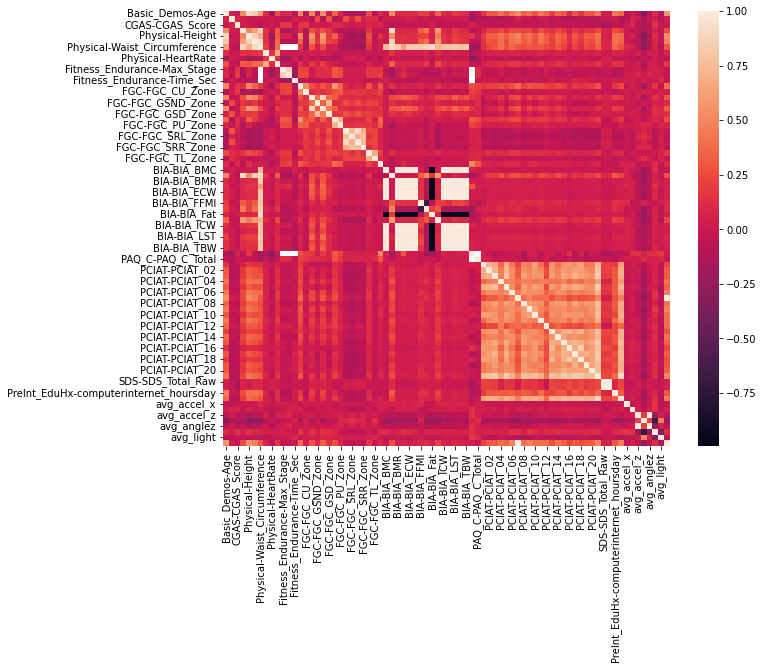

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
# df_temp = df[[col for col in df.columns if col.startswith('FGC')] + ['sii','PCIAT-PCIAT_Total']]
# df = df.loc[:, ['sii','Basic_Demos-Age','Basic_Demos-Sex','Physical-Waist_Circumference','CGAS-CGAS_Score','Physical-BMI','Physical-Diastolic_BP','Physical-HeartRate']]
# sns.pairplot(df_temp)

df_numeric = df.select_dtypes(include=['number'])
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix)


In [54]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)]
# good_corr.to_excel('corr_matrix_05.xlsx')

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,avg_accel_x,avg_accel_y,avg_accel_z,avg_enmo,avg_anglez,sum_non_wear_flag,avg_light,height_pciat_07
Basic_Demos-Age,1.000000,NaN,NaN,0.514899,0.895008,0.817525,0.609601,NaN,NaN,NaN,NaN,NaN,NaN,0.501687,NaN,NaN,NaN,0.531536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.502853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.558529
Basic_Demos-Sex,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CGAS-CGAS_Score,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Physical-BMI,0.514899,NaN,NaN,1.000000,NaN,0.614169,0.877467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.912002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Physical-Height,0.895008,NaN,NaN,NaN,1.000000,0.864769,0.688221,NaN,NaN,NaN,NaN,NaN,NaN,0.506497,NaN,0.542405,NaN,0.592032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.511193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.503650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.533991
Physical-Weight,0.817525,NaN,NaN,0.614169,0.864769,1.000000,0.916027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.511198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.856314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.593520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Physical-Waist_Circumference,0.609601,NaN,NaN,0.877467,0.688221,0.916027,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.744749,0.920539,0.830669,0.603203,0.818122,0.830669,0.809447,0.861946,0.915948,0.716520,0.794825,0.796639,0.833994,0.785021,0.824784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Physical-Diastolic_BP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.657705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [49]:
df.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

In [2]:
import pandas as pd

pd.read_csv('child-mind-institute-problematic-internet-use/test.csv')

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,...,63.1265,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring,0.0
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,...,47.2211,NaN,NaN,Winter,3.670,Winter,27.0,40.0,Fall,3.0
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,...,50.4767,NaN,NaN,Fall,1.270,NaN,NaN,NaN,Fall,2.0
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.0
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
